## ASTR 598 Astrostatistics

## HW4 - Classification of QSO and Stars

### Dino Bektsevic, Meredith Durbin, Tyler Gordon, Joachim Moeyens, Brianna Thomas

The files for this notebook and the code to read them were generously provided by Group 2 (Chris Suberlak, Hayden Smotherman, Winnie Wang). These files are located on Joachim's [Google Drive](https://drive.google.com/drive/folders/1r3o2I9iK6nrSDbbXTBX-YJM81BzIvAbh) (link will be disabled after the quarter is over).



## Machine Learning Classifiers
- [Linear Discriminant Analysis](#Linear-Discriminant-Analysis)
- [Gaussian Mixture Models](#Gaussian-Mixture-Models)
- [Support Vector Machine](#Support-Vector-Machine)
- [The Fun Stuff](#Neural-Networks)

In [1]:
import numpy as np
from astropy.table import Table
from astropy.table import hstack

from sklearn.svm import SVC
from astroML.classification import GMMBayes

from astroML.decorators import pickle_results
from astroML.utils import split_samples
from astroML.utils import completeness_contamination
from astroML.plotting.tools import draw_ellipse

from sklearn.metrics import roc_curve

import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
# Load the QSO training sample
qso = Table(np.load('hlc_nsc_sdss_qso_matches.npy'))

# Load the standard stars training sample 
stars = Table(np.load('hlc_nsc_sdss_stars_matches.npy'))

In [3]:
#de-reddening apparent magnitudes based on 
def make_dereddened_colors(table):
    # Make column with HLC dereddened magnitudes 
    filters = 'ugriz'
    for f in filters : 
        table['HLC'+f+'mag_dered'] = table['HLC'+f+'mag'] - table['HLC'+f+'RED']

    # Make column with HLC colors based on dereddened magnitudes
    for i in range(len(filters)-1):
        f1,f2 = filters[i], filters[i+1]
        table['HLC'+f1+'-'+f2] = table['HLC'+f1+'mag_dered']-table['HLC'+f2+'mag_dered']
        
#make_dereddened_colors(hlc_nsc)
make_dereddened_colors(stars)
make_dereddened_colors(qso)

In [4]:
np.warnings.filterwarnings("ignore")

def fetch_dr14_quasars(qso):
    # SDSS DR14 QSO cross-matched to HLC-NSC catalog 
    # --> signal / noise > 5 
    m_g_sn = qso['HLCgmag'] / qso['HLCgerr'] > 5
    m_u_sn = qso['HLCumag'] / qso['HLCuerr'] > 5
    m_r_sn = qso['HLCrmag'] / qso['HLCrerr'] > 5
    m_redshift = qso['Z'] < 2.5

    m = m_g_sn * m_u_sn * m_r_sn  * m_redshift
    print('We select ', np.sum(m), ' of ', len(m))
    quasars = qso[m]
    return quasars

def fetch_standard_stars(stars):
    # STARS
    # --> signal / noise > 5 
    m_g_sn = stars['HLCgmag'] / stars['HLCgerr'] > 5
    m_u_sn = stars['HLCumag'] / stars['HLCuerr'] > 5
    m_r_sn = stars['HLCrmag'] / stars['HLCrerr'] > 5

    m =  m_g_sn * m_u_sn* m_r_sn
    print('We select ', np.sum(m), ' of ', len(m))
    stars = stars[m]
    return stars

quasars =  fetch_dr14_quasars(qso)
stars = fetch_standard_stars(stars)

# stack colors into matrix X : it is the training set 
# size : ( number of qso + number of stars ) * ( number of colors )
Nqso = len(quasars)
Nstars = len(stars)
X = np.empty((Nqso + Nstars, 4), dtype=float)

X[:Nqso, 0] = quasars['HLCu-g']
X[:Nqso, 1] = quasars['HLCg-r']
X[:Nqso, 2] = quasars['HLCr-i']
X[:Nqso, 3] = quasars['HLCi-z']

X[Nqso:, 0] = stars['HLCu-g']
X[Nqso:, 1] = stars['HLCg-r']
X[Nqso:, 2] = stars['HLCr-i']
X[Nqso:, 3] = stars['HLCi-z']

# Make a vector with labels 
y = np.zeros(Nqso + Nstars, dtype=int)
y[:Nqso] = 1  # 1 = qso ,  0 = star 

# split into training and test sets
(X_train, X_test), (y_train, y_test) = split_samples(X, y, [0.9, 0.1],
                                                     random_state=0)

We select  7250  of  22205
We select  260872  of  693857


## Linear Discriminant Analysis 


## Gaussian Mixture Models

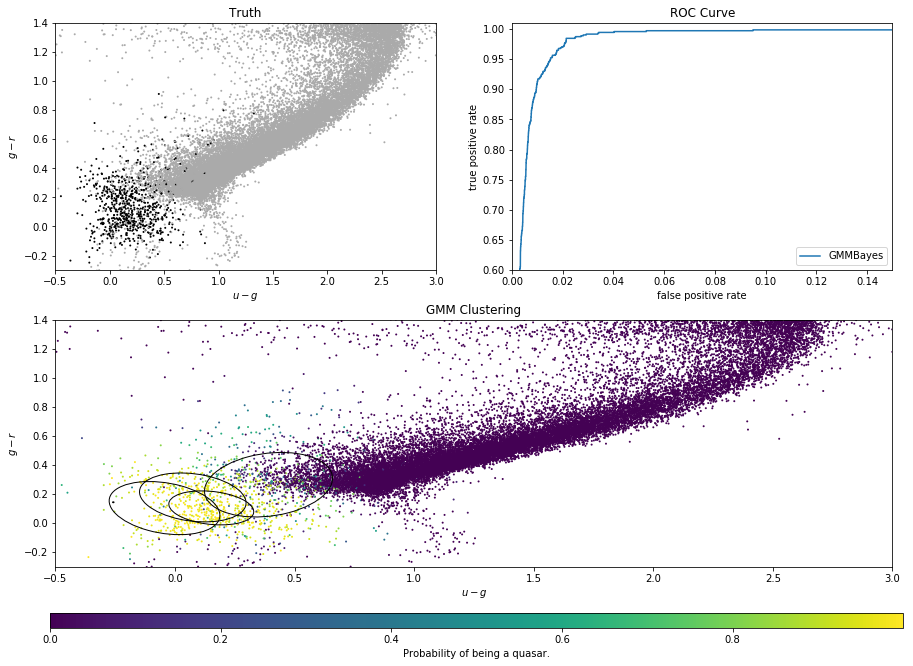

In [5]:
classifier = GMMBayes(n_components=5, min_covar=1E-5, covariance_type='full')
classifier.fit(X_train, y_train)

predictions = classifier.predict_proba(X_test)
y_prob = predictions[:, 1]

plt.figure(figsize=(15,10))


#####################################################################################
############################# TRUE RESULTS ##########################################
#####################################################################################

ax = plt.subplot(221)

im = plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=4, linewidths=0, edgecolors='none', cmap=plt.cm.binary)
im.set_clim(-0.5, 1)

ax.set_xlim(-0.5, 3.0)
ax.set_ylim(-0.3, 1.4)
ax.set_xlabel('$u - g$')
ax.set_ylabel('$g - r$')
ax.set_title("Truth")


#####################################################################################
#############################     ROC      ##########################################
#####################################################################################
ax = plt.subplot(222)

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
ax.plot(fpr, tpr, label="GMMBayes")

ax.legend(loc=4)
ax.set_xlabel('false positive rate')
ax.set_ylabel('true positive rate')
ax.set_xlim(0, 0.15)
ax.set_ylim(0.6, 1.01)
ax.set_title("ROC Curve")


#####################################################################################
############################  PREDICTIONS  ##########################################
#####################################################################################
ax = plt.subplot(212)

im = plt.scatter(X_test[:, 0], X_test[:, 1], c=y_prob, s=4, edgecolors="None")
ax.set_xlim(-0.5, 3.0)
ax.set_ylim(-0.3, 1.4)
ax.set_xlabel('$u - g$')
ax.set_ylabel('$g - r$')
ax.set_title("GMM Clustering")

#which gmms is it?
for i in range(classifier.n_components[0]):
    mean = classifier.gmms_[1].means_[i]
    cov = classifier.gmms_[1].covars_[i]
    if cov.ndim == 1:
        cov = np.diag(cov)
    draw_ellipse(mean, cov, ax=plt.gca(), scales=[1], fc='none', ec='black', zorder=2)

# colorbars man....
cbar_ax = plt.gcf().add_axes(([0.12, 0.04, 0.79, 0.02]))
plt.colorbar(im, cax=cbar_ax, orientation="horizontal", label="Probability of being a quasar.")

plt.show()

### Get classification correctness per color dimension

completeness [ 0.625       0.6741573   0.84129213  0.9002809 ]
contamination [ 0.35507246  0.26493109  0.21391076  0.27977528]


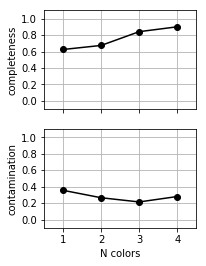

In [7]:
classifiers = []
predictions = []
Ncolors = np.arange(1, X.shape[1] + 1)

for nc in Ncolors:
    clf = GMMBayes(n_components=5, min_covar=1E-5, covariance_type='full')
    clf.fit(X_train[:, :nc], y_train)
    y_pred = clf.predict(X_test[:, :nc])

    classifiers.append(clf)
    predictions.append(y_pred)

completeness, contamination = completeness_contamination(predictions, y_test)

print("completeness", completeness)
print("contamination", contamination)

# Plot completeness vs Ncolors
ax = plt.subplot(222)
ax.plot(Ncolors, completeness, 'o-k', ms=6)

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.NullFormatter())

ax.set_ylabel('completeness')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

# Plot contamination vs Ncolors
ax = plt.subplot(224)
ax.plot(Ncolors, contamination, 'o-k', ms=6)

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%i'))

ax.set_xlabel('N colors')
ax.set_ylabel('contamination')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)
plt.show()

### Classification correctness per number of components

completeness [ 0.28230337  0.78932584  0.7752809   0.76685393  0.9002809   0.91011236
  0.89606742  0.88764045  0.87219101  0.88623596  0.87780899  0.88061798
  0.86797753  0.89466292]
contamination [ 0.39820359  0.50133097  0.34128878  0.22881356  0.28058361  0.27839644
  0.2572759   0.24220624  0.19663648  0.20728643  0.19974392  0.21625
  0.1974026   0.20075282]


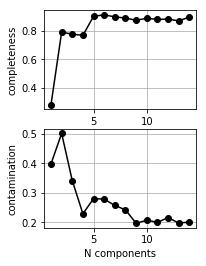

In [9]:
predictions = []
classifiers = []
Ncomponents = range(1, 15)

for nc in Ncomponents:
    clf = GMMBayes(n_components=nc, min_covar=1E-5, covariance_type='full')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    classifiers.append(clf)
    predictions.append(y_pred)
    
completeness, contamination = completeness_contamination(predictions, y_test)

print("completeness", completeness)
print("contamination", contamination)

# Plot completeness vs Ncomponents
ax = plt.subplot(222)
ax.plot(Ncomponents, completeness, 'o-k', ms=6)

ax.set_ylabel('completeness')
ax.grid(True)

# Plot contamination vs Ncomponents
ax = plt.subplot(224)
ax.plot(Ncomponents, contamination, 'o-k', ms=6)

ax.set_xlabel('N components')
ax.set_ylabel('contamination')
ax.grid(True)

plt.show()

## Support Vector Machine

@pickle_results: using precomputed results from 'SVM_qso.pkl'
completeness [ 0.95786517  0.95505618  0.95505618  0.95365169]
contamination [ 0.66764133  0.63063552  0.61840629  0.6183249 ]


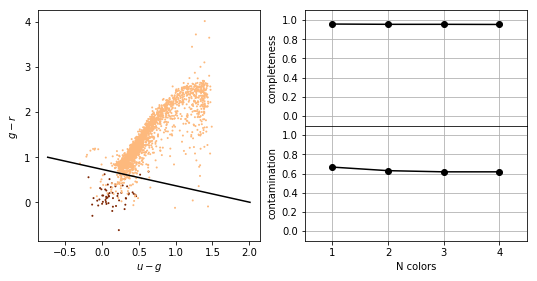

In [16]:
N_tot = len(y)
N_st = np.sum(y == 0)
N_qso = N_tot - N_st
N_train = len(y_train)
N_test = len(y_test)
N_plot = 5000 + N_qso

#----------------------------------------------------------------------
# Fit SVM
Ncolors = np.arange(1, X.shape[1] + 1)

@pickle_results('SVM_qso.pkl')
def compute_SVM(Ncolors):
    classifiers = []
    predictions = []

    for nc in Ncolors:
        # perform support vector classification
        clf = SVC(kernel='linear', class_weight='balanced')
        clf.fit(X_train[:, :nc], y_train)
        y_pred = clf.predict(X_test[:, :nc])

        classifiers.append(clf)
        predictions.append(y_pred)

    return classifiers, predictions

classifiers, predictions = compute_SVM(Ncolors)

completeness, contamination = completeness_contamination(predictions, y_test)

print ("completeness", completeness)
print ("contamination", contamination)

#------------------------------------------------------------
# compute the decision boundary
clf = classifiers[1]
w = clf.coef_[0]
a = -w[0] / w[1]
yy = np.linspace(0, 1)
xx = a * yy - clf.intercept_[0] / w[1]

#----------------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(8, 4))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0,
                    left=0.1, right=0.95, wspace=0.2)

# left plot: data and decision boundary
ax = fig.add_subplot(121)
ax.plot(xx, yy, '-k')
im = ax.scatter(X[-N_plot:, 1], X[-N_plot:, 0], c=y[-N_plot:],
                s=4, lw=0, cmap=plt.cm.Oranges, zorder=2)
im.set_clim(-0.5, 1)

#ax.set_xlim(0.7, 1.35)
#ax.set_ylim(-0.15, 0.4)

ax.set_xlabel('$u-g$')
ax.set_ylabel('$g-r$')

# plot completeness vs Ncolors
ax = fig.add_subplot(222)
ax.plot(Ncolors, completeness, 'o-k')

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.NullFormatter())

ax.set_ylabel('completeness')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

# plot contamination vs Ncolors
ax = fig.add_subplot(224)
ax.plot(Ncolors, contamination, 'o-k')

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%i'))

ax.set_xlabel('N colors')
ax.set_ylabel('contamination')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

plt.show()

## Neural Networks